# 🪪 Project #3 - Identity Fraud Detection Analysis and Model Training
*by Andrew Kim - kim.andrew.j1@gmail.com*

## 🎯 Objective
Build and evaluate an identity fraud detection (IFD) model by integrating transaction data with device and behavioral features from multiple sources.

Develop a comprehensive detection system and to apply standard AI/ML techniques to preprocess, explore, and model the data.

---

## 🗂️ The Dataset (`train_transaction.csv` & `train_identity.csv`)
The dataset is derived from a real-world identity fraud detection challenge. It includes 2 files:
- `train_transaction.csv`: contains transaction-level features and the target variable `isFraud`
- `train_identity.csv`: contains identity features associated with the transactions
- Features are labeled generically (e.g., `V1`, `C1`, `D9`, `id_12`, etc.) for privacy and proprietary reasons

Dataset will be merged them using the `TransactionID` key. 

---

## ✅ Project Tasks
1. **Import & Merge Data**
  - Check for missing values and display merged dataset
  - Describe how much identity data was missing

2. **Feature Preprocessing**
  - Drop columns with over 75% missing values and fill missing values using mean or mode
  - Encode categorical features like `DeviceType`, `id_12`, or `P_emaildomain`

3. **Model Training**
  - Split data 80/20 and train Random Forest with following parameters (`n_estimators=100`, `max_depth=8`, `random_state=42`)
  - Train the model and make predictions

4. **Model Evaluation**
  - Generate a confusion matrix
  - Report `Precision`, `Recall`, `F1-score`, `ROC-AUC`

5. **Imbalanced Data Handling**
  - Implement SMOTE (Synthetic Minority Oversampling Technique) and Undersampling to balance classes
  - Re-train, evaluate, and analyze changes in `Precision`/`Recall` performanceactionID` key.

---

In [1]:
# =====================================
# DATA MERGING & EXPLORATION
# =====================================

# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display, Markdown

display(Markdown("## Data Merging & Exploration"))

# Load datasets
transaction_df = pd.read_csv("train_transaction.csv")
identity_df = pd.read_csv("train_identity.csv")

# Merge with TransactionID
df = pd.merge(transaction_df, identity_df, how='left', on='TransactionID')

# Preview
  # Display preview of transaction_df
display(Markdown("### First 5 Rows of `transaction_df`"))
display(transaction_df.head())

# Display preview of identity_df
display(Markdown("### First 5 Rows of `identity_df`"))
display(identity_df.head())

# Preview the merged dataset
display(Markdown("### First 5 Rows of Merged Dataset"))
display(df.head())

# Check for missing values
display(Markdown("### Missing Values Summary"))
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

# Create a summary table of missing values
missing_df = pd.DataFrame({'Missing_Count': missing_summary,'Missing_Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing_Count'] > 0]
print(f"Columns with missing values: {len(missing_df)}")
display(missing_df.head(10))

# Display shape and preview merged dataset
display(Markdown("### Dataset Shape and Info"))
print(f"Transaction dataset shape: {transaction_df.shape}")
print(f"Identity dataset shape: {identity_df.shape}")
print(f"Merged dataset shape: {df.shape}")

# Identity data coverage analysis
identity_coverage = len(identity_df) / len(transaction_df) * 100
print(f"\nIdentity data coverage: {identity_coverage:.2f}% of transactions have identity information")

# Preview merged dataset
display(Markdown("### Sample of Merged Dataset"))
display(df.head())

# Basic statistics
display(Markdown("### Fraud Distribution"))
fraud_dist = df['isFraud'].value_counts()
fraud_pct = df['isFraud'].value_counts(normalize=True) * 100
print(f"Non-Fraud: {fraud_dist[0]} ({fraud_pct[0]:.2f}%)")
print(f"Fraud: {fraud_dist[1]} ({fraud_pct[1]:.2f}%)")

## Data Merging & Basic Exploration

### First 5 Rows of `transaction_df`

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### First 5 Rows of `identity_df`

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### First 5 Rows of Merged Dataset

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Missing Values Summary

Columns with missing values: 414


,Missing_Count,Missing_Percentage
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_27,585371,99.124699
id_23,585371,99.124699
id_22,585371,99.124699
dist2,552913,93.628374


### Dataset Shape and Info

Transaction dataset shape: (590540, 394)
Identity dataset shape: (144233, 41)
Merged dataset shape: (590540, 434)

Identity data coverage: 24.42% of transactions have identity information


### Sample of Merged Dataset

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Fraud Distribution

Fraud Distribution:
Non-Fraud: 569877 (96.50%)
Fraud: 20663 (3.50%)


# **Observations - Dataset (train_transaction.csv & train_identity.csv)**
- **Merged** **`2`** datasets
  - **590,540** Credit Card transactions
  - **394** Transaction features + **41** Identity features = **434** *combined* features
    - **Features:** **414** Columns *missing* values (**`NaN`**); column **`id_24`** with highest percentage of missing value
    - **Features:** **75.58%** of transactions *missing* values (Identity and/or Transaction features)
  - **96.50%** identified as **Legitimate transactions**, **3.5%** identified as **fraudulent**
    - **Insight:** Merged dataset **highly imbalanced** and **incomplete (missing features)**
    - **Insight:** Merged dataset needs to be **treated** prior to being used for model training

In [2]:
# =====================================
# FEATURE PREPROCESSING
# =====================================

display(Markdown("## Feature Preprocessing"))

# Drop columns with over 75% missing values
display(Markdown("### Dropping High-Missing Columns"))
threshold = 0.75
missing_fraction = df.isnull().mean()
columns_to_drop = missing_fraction[missing_fraction > threshold].index.tolist()

print(f"Columns to drop (>75% missing): {len(columns_to_drop)}")
print(f"Columns: {columns_to_drop}")

df_cleaned = df.drop(columns=columns_to_drop)
print(f"Shape after dropping high-missing columns: {df_cleaned.shape}")

# Identify categorical columns for encoding
display(Markdown("### Categorical Feature Encoding"))
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns found: {categorical_cols}")

# Encode categorical features using label encoding
df_encoded = df_cleaned.copy()
label_encoders = {}

for col in categorical_cols:
    if col != 'TransactionID':
        le = LabelEncoder()
        df_encoded[col] = df_encoded[col].fillna('Unknown')
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique categories")

# Fill missing values for numerical columns
display(Markdown("### Handling Missing Values"))
numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['isFraud', 'TransactionID']]

# Count columns with missing values before filling
cols_with_missing = [col for col in numerical_cols if df_encoded[col].isnull().sum() > 0]
if cols_with_missing:
    print(f"Filling missing values for {len(cols_with_missing)} numerical columns...")
    
    # Fill with median (more robust than mean for fraud data) - fixed pandas warning
    for col in cols_with_missing:
        median_val = df_encoded[col].median()
        df_encoded[col] = df_encoded[col].fillna(median_val)
else:
    print("No missing values found in numerical columns.")

# Final check for missing values
display(Markdown("### Final Missing Values Check"))
print(f"Final dataset shape: {df_encoded.shape}")
final_missing = df_encoded.isnull().sum().sum()
print(f"Total missing values after preprocessing: {final_missing}")

if final_missing == 0:
    print("✅ All missing values handled successfully!")
else:
    remaining_missing = df_encoded.isnull().sum()
    remaining_missing = remaining_missing[remaining_missing > 0]
    print("⚠️  Remaining missing values:")
    display(remaining_missing)


# Store the cleaned dataset
df_final = df_encoded
display(Markdown("### Preprocessing Complete"))
print("✅ Dataset ready for modeling!")

## Feature Preprocessing

### Dropping High-Missing Columns

Columns to drop (>75% missing): 208
Columns: ['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V2

### Categorical Feature Encoding

Categorical columns found: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
Encoded ProductCD: 5 unique categories
Encoded card4: 5 unique categories
Encoded card6: 5 unique categories
Encoded P_emaildomain: 60 unique categories
Encoded M1: 3 unique categories
Encoded M2: 3 unique categories
Encoded M3: 3 unique categories
Encoded M4: 4 unique categories
Encoded M5: 3 unique categories
Encoded M6: 3 unique categories
Encoded M7: 3 unique categories
Encoded M8: 3 unique categories
Encoded M9: 3 unique categories


### Handling Missing Values

Filling missing values for 194 numerical columns...


### Final Missing Values Check

Final dataset shape: (590540, 226)
Total missing values after preprocessing: 0
✅ All missing values handled successfully!


### Preprocessing Complete

✅ Dataset ready for modeling!


# **Observations - Feature Preprocessing**
- Preparing Dataset for modeling by **eliminating columns** lacking data
  - Not *all* columns will be eliminated nor will *all* remaining columns have values (until preprocessing completed)
  - **Threshold:** Eliminated columns missing at least 75% of data
    - All **Identity** features eliminated due to *lack of data* (99+% missing) 
    - Resulted in **New dataset** with **`590,540` transactions**, **`226` features** (maintaining original number of transactions)
- **Descriptive (word-based) data** converted to **Numeric data** for easier data handling (**`13` features**)
- **Filled in** missing values for **`194` Numerical features** using **median** values v. mean or mode
    - Median values **less likely** to be influenced by outliers

In [3]:
# =====================================
# RANDOM FOREST MODEL TRAINING
# =====================================

display(Markdown("## Random Forest Model Training"))

# Prepare features and target
X = df_final.drop(['isFraud', 'TransactionID'], axis=1)
y = df_final['isFraud']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Split the data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Testing fraud rate: {y_test.mean():.4f}")

# Train Random Forest model
display(Markdown("### Training Random Forest Model"))
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)

print("Random Forest Model training...")
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Show just a small sample
print(f"Sample Fraud Predictions (first 10): {y_pred[:10]}")
print(f"Sample Fraud Probabilities (first 10): {y_pred_proba[:10].round(4)}")

print(f"\n✅ Random Forest Model training complete and saved!")

## Random Forest Model Training

Feature matrix shape: (590540, 224)
Target distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Training set shape: (472432, 224)
Testing set shape: (118108, 224)
Training fraud rate: 0.0350
Testing fraud rate: 0.0350


### Training Random Forest Model

Random Forest Model training...
Sample Fraud Predictions (first 10): [0 0 0 0 0 0 0 0 0 0]
Sample Fraud Probabilities (first 10): [0.0055 0.033  0.0147 0.0058 0.0051 0.0173 0.0565 0.005  0.0196 0.0314]

✅ Random Forest Model training complete and saved!


# **Observations - Random Forest Model**
- **Random Forest Classifier Model** using Dataset edited for preprocessing
  - **Features (X):** All columns except **`isFraud`** and **`TransactionID`** (**`224`** Total)
  - **Target (y):** **'isFraud`** column indicates whether a transaction is **fraudulent**
  - **Fraud distribution** *matches* fraud distribution rate from Merged Dataset (**3.5%**)
  - Split the data **`80%`** for training (**472,432** transactions) and **`20%`** for testing (**118,108** transactions), maintaining the **same fraud rate** (**3.5%**)
- Trained the Random Forest model and generated a small sample of fraud predictions and their probabilities.
  - **Insight:** The first **10 predictions** were all **`Legitimate`**, with probabilities mostly **under 6%**

## Imbalanced Random Forest Model Evaluation

### Confusion Matrix

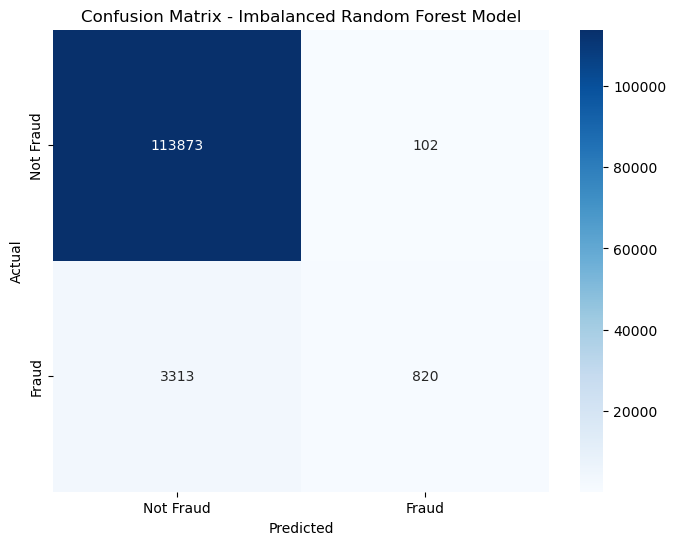

### Performance Metrics

Precision: 0.8894
Recall: 0.1984
F1-Score: 0.3244
ROC-AUC: 0.8673


### Detailed Classification Report

              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.99    113975
       Fraud       0.89      0.20      0.32      4133

    accuracy                           0.97    118108
   macro avg       0.93      0.60      0.65    118108
weighted avg       0.97      0.97      0.96    118108



### ROC Curve

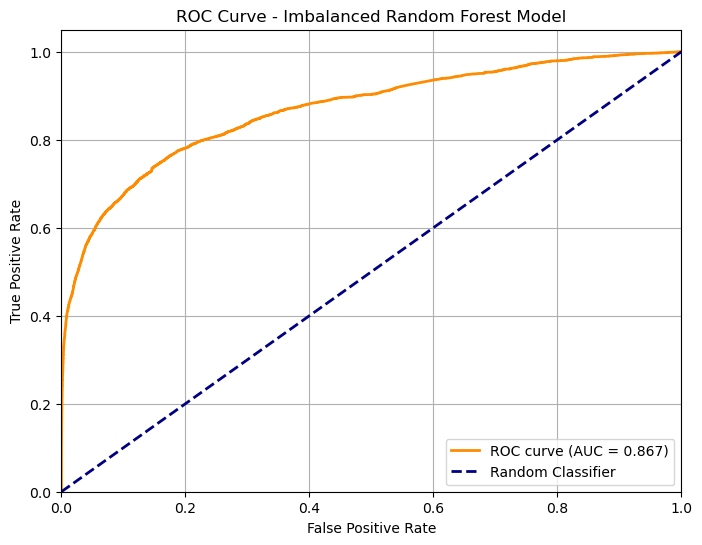


✅ Analysis complete!


In [4]:
# =====================================
# RANDOM FOREST MODEL EVALUATION
# =====================================

display(Markdown("## Imbalanced Random Forest Model Evaluation"))

# Generate confusion matrix
display(Markdown("### Confusion Matrix"))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix - Imbalanced Random Forest Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display metrics
display(Markdown("### Performance Metrics"))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Detailed classification report
display(Markdown("### Detailed Classification Report"))
print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

# ROC Curve
display(Markdown("### ROC Curve"))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Imbalanced Random Forest Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n✅ Analysis complete!")

# **Observations - Imbalanced Random Forest Model Evauluation**

## **Confusion Matrix**
- Model **incorrectly** identified **`3,313`** **Fraudulent transactions** as **legitimate**
    - *High* rate of **False Negatives** 
- Model **incorrrectly** identified **`102`** **Legitimate transactions** as **fraudulent**
    - *Low* rate of **False Positives**

## **Performance Metrics**
- **`Precision`** = **`.8894`** = True Positive/(True Positive + False Positive)
    - Of all transactions flagged as fraud, **`88.94%`** were **actually fraud**; **`11.06%`** were **falsely flagged** (false positives)
- **`Recall`** = **`.1984`** = True Positive/(True Positive + False Negative)
    - Of all Fraudulent transactions, **`19.84%`** were **correctly identified** as fraud; **`80.16%`** of actually fraudulent transactions were **not identified** (false negatives)
- **`F-1 Score`** = **`.3244`** = 2 * (Precision * Recall)/(Precision + Recall)
- **`ROC-AUC`** = **`86.73%`**
  - **Insight:** **Precision** is **high** while **Recall** is **extremely low**, raising concerns about *high failure rate* of **incorrectly identifying** fraudulent transactions (false negatives)
  - **Insight:** **Low Recall** affects **F-1 Score**, meaning improvements can be made by *balancing data* or *editing model parameters* (i.e., **`n_estimators`**, **`max_depth`**)
  - **Insight:** Firms must balance **High Precision** (better customer experience) v. **Low Recall** (missing Fraudulent transactions)

## **Detailed Classification Report**
- **`support`** = Actual count of each transaction class in **Test set**: 113,975 Legitimate transactions v. 4,133 Fraudulent transactions
- **`macro avg`** = Simple average across **both** classes (**`93%`** **`Precision`**; **`60%`** **`Recall`**)
  - Treats **Fraudulent** and **Legitimate** transactions *equally*, but reveals **poor Recall** ability
- **`weighted avg`** = Size-weighted average (**`97%`** **`Precision`**; **`97%`** **`Recall`**)
  - **Legitimate transactions** data *greatly outweighs* **Fraudulent transactions** data, *skewing* results to show model is performing better than it truly is

## **ROC Curve**
- **AUC** = **`86.7%`** = Model performs significantly better than Random (see Random Classifier baseline 50/50)
- **Curve shape** = Good separation but greater optimization could be needed
- **Distance** from Random Classifier baseline shows model has learned meaningful patterns despite **poor Recall**
  - **Insight:** **High AUC** suggests Random Forest model has *potential*, but **poor Recall** may be due to conservative threshold rather than inability to distinguish fraud patterns

## Imbalanced Data Handling

Original training dataset distribution:
Not Fraud: 455902 (96.5%)
Fraud: 16530 (3.5%)


### Method 1: SMOTE (Synthetic Minority Oversampling Technique)

Applying SMOTE...
SMOTE training set distribution:
Not Fraud: 455902 (50.0%)
Fraud: 455902 (50.0%)

Training model with SMOTE data...


### Method 2: Random Undersampling

Applying Random Undersampling...
Undersampled training set distribution:
Not Fraud: 16530 (50.0%)
Fraud: 16530 (50.0%)

Training model with Undersampled data...

✅ Model training complete and saved!


### Model Performance Comparison

,Model,Precision,Recall,F1-Score,ROC-AUC
0,Imbalanced Random Forest Model,0.8894,0.1984,0.3244,0.8673
1,SMOTE Model,0.3119,0.5054,0.3857,0.8563
2,Undersampling Model,0.1434,0.7692,0.2418,0.8750


### Visual Performance Comparison

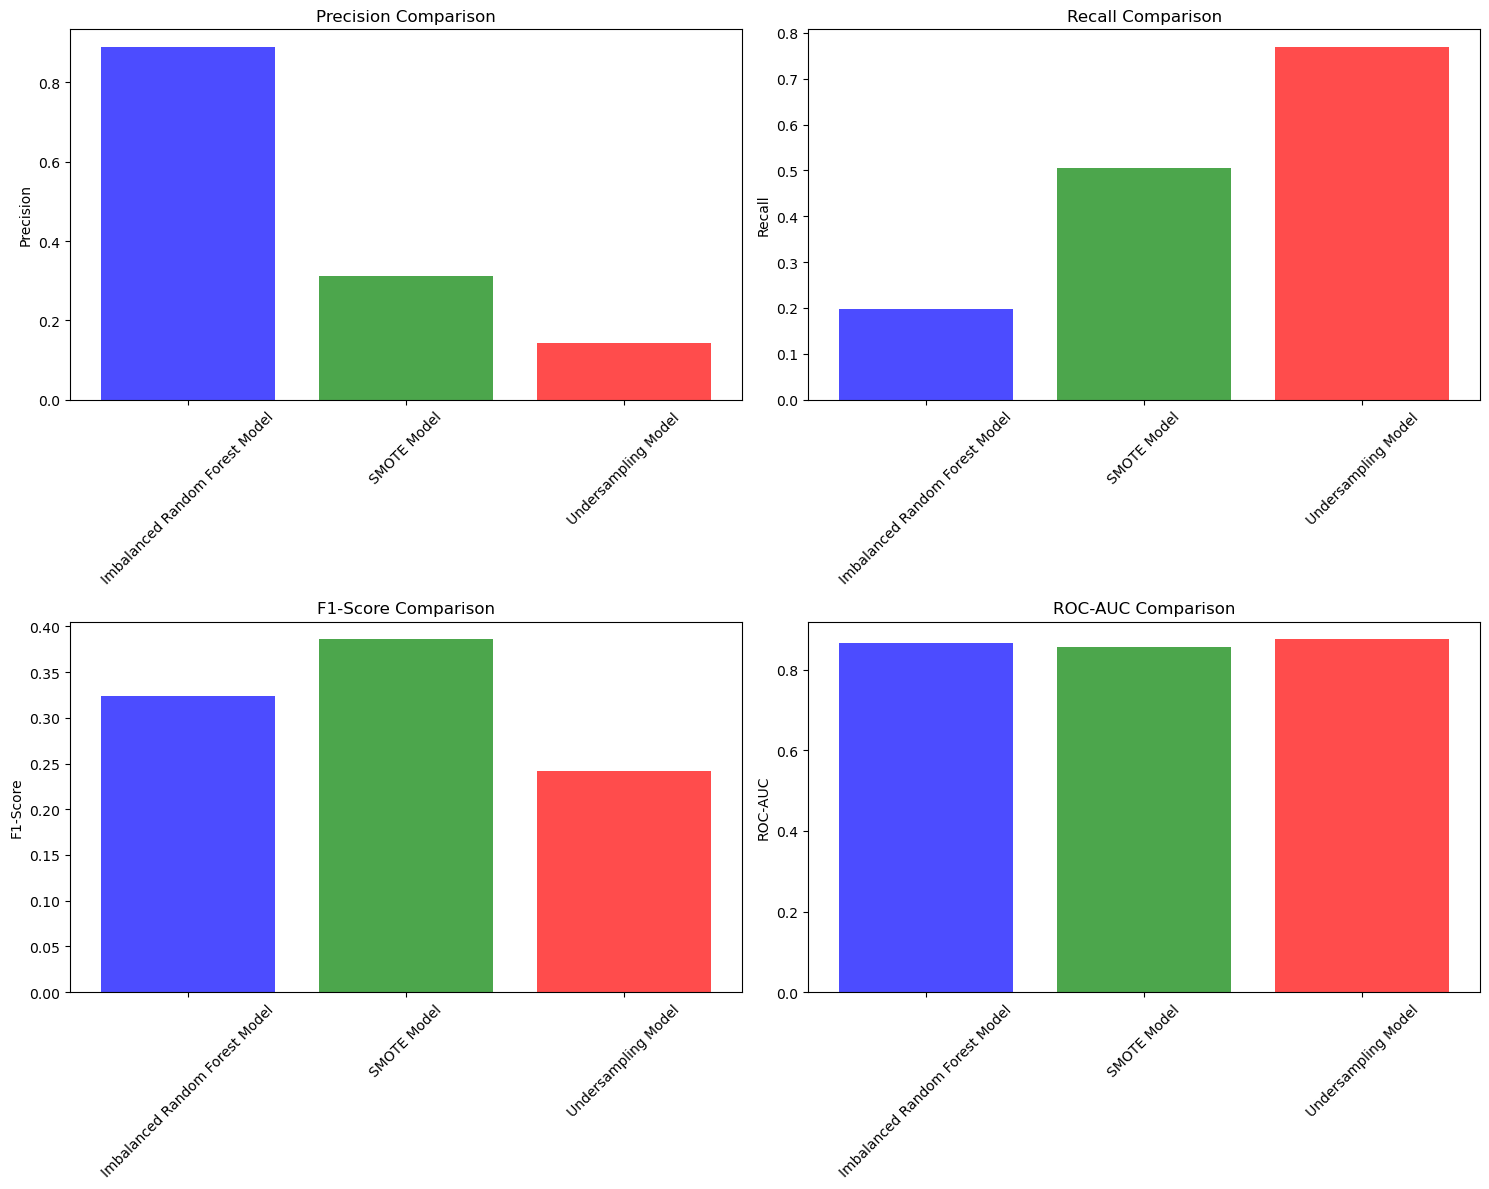

### Confusion Matrices Comparison

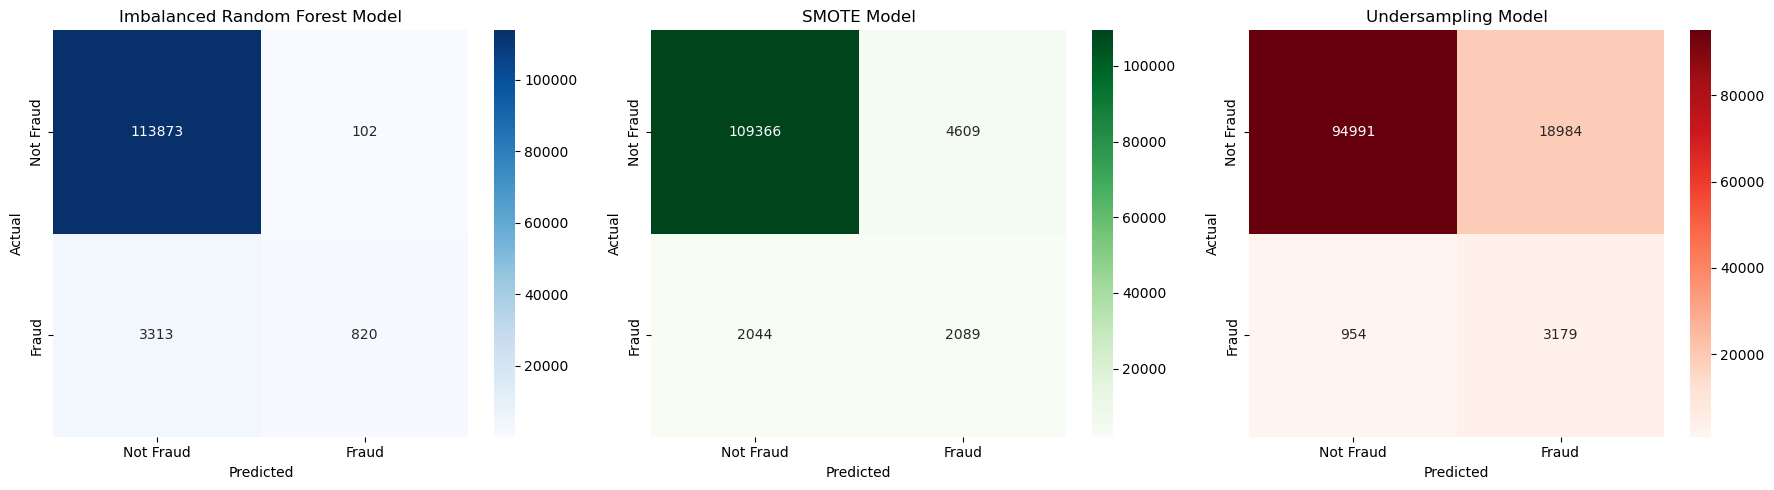


✅ Analysis complete!


In [9]:
# =====================================
# IMBALANCED DATA HANDLING
# =====================================

display(Markdown("## Imbalanced Data Handling"))

##display(Markdown("### Original Class Distribution"))
print("Original training dataset distribution:")
print(f"Not Fraud: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"Fraud: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

# Method 1: SMOTE (Oversampling)
display(Markdown("### Method 1: SMOTE (Synthetic Minority Oversampling Technique)"))

print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE training set distribution:")
print(f"Not Fraud: {(y_train_smote == 0).sum()} ({(y_train_smote == 0).mean():.1%})")
print(f"Fraud: {(y_train_smote == 1).sum()} ({(y_train_smote == 1).mean():.1%})")

# Train model with SMOTE data
print("\nTraining model with SMOTE data...")
model_smote = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Predictions with SMOTE Model
y_pred_smote = model_smote.predict(X_test)
y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# Method 2: Undersampling Model
display(Markdown("### Method 2: Random Undersampling"))
print("Applying Random Undersampling...")
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("Undersampled training set distribution:")
print(f"Not Fraud: {(y_train_under == 0).sum()} ({(y_train_under == 0).mean():.1%})")
print(f"Fraud: {(y_train_under == 1).sum()} ({(y_train_under == 1).mean():.1%})")

# Train model with undersampled data
print("\nTraining model with Undersampled data...")
model_under = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
model_under.fit(X_train_under, y_train_under)

# Predictions with Undersampled Model
y_pred_under = model_under.predict(X_test)
y_pred_proba_under = model_under.predict_proba(X_test)[:, 1]

print("\n✅ Model training complete and saved!")

# =====================================
# MODEL COMPARISON
# =====================================

display(Markdown("### Model Performance Comparison"))

# Calculate metrics for all models
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    return {'Model': model_name,
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)}

# Collect all metrics
results = []
results.append(calculate_metrics(y_test, y_pred, y_pred_proba, 'Imbalanced Random Forest Model'))
results.append(calculate_metrics(y_test, y_pred_smote, y_pred_proba_smote, 'SMOTE Model'))
results.append(calculate_metrics(y_test, y_pred_under, y_pred_proba_under, 'Undersampling Model'))

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.round(4)

display(comparison_df)

# Visualize comparison
display(Markdown("### Visual Performance Comparison"))
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Precision comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Precision'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0,0].set_title('Precision Comparison')
axes[0,0].set_ylabel('Precision')
axes[0,0].tick_params(axis='x', rotation=45)

# Recall comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['Recall'], color=['blue', 'green', 'red'], alpha=0.7)
axes[0,1].set_title('Recall Comparison')
axes[0,1].set_ylabel('Recall')
axes[0,1].tick_params(axis='x', rotation=45)

# F1-Score comparison
axes[1,0].bar(comparison_df['Model'], comparison_df['F1-Score'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1,0].set_title('F1-Score Comparison')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['ROC-AUC'], color=['blue', 'green', 'red'], alpha=0.7)
axes[1,1].set_title('ROC-AUC Comparison')
axes[1,1].set_ylabel('ROC-AUC')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Confusion matrices comparison
display(Markdown("### Confusion Matrices Comparison"))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Imbalanced Random Forest model
cm_orig = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
axes[0].set_title('Imbalanced Random Forest Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# SMOTE model
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
axes[1].set_title('SMOTE Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# Undersampling model
cm_under = confusion_matrix(y_test, y_pred_under)
sns.heatmap(cm_under, annot=True, fmt='d', cmap='Reds', ax=axes[2],
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
axes[2].set_title('Undersampling Model')
axes[2].set_ylabel('Actual')
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")

# **Observations - Model Comparison**
- **SMOTE:** Random Forest model trained using **synthetically balanced data** (to *mimic* Fraudulent transactions)
- **Undersampling:** Random Forest model trained using **randomly balanced data** (to *match* number of Fraudulent transactions)   

## **SMOTE Results**
- **`Precision`** = **`.3119`**
    - Compared to Imbalanced Random Forest Model, **`Precision`** *decreased* by **`0.5775`** from **`.8894`**
        - **Insight:** *More* **Legitimate transactions** flagged as **fraudulent**, *decreasing* customer experience 
- **`Recall`** = **`.5054`**
    - Compared to Imbalanced Random Forest Model, **`Recall`** *increased* by **`0.307`** from **`.1984`**
        - **Insight:** *Less* **Fraudulent transactions** being **missed**, *increasing* fraud detection
- **SMOTE Model** *reduced* **`Precision`** but *improved* **`Recall`**
  - *Improved* capturing **Actual Fraudulent transactions** but at expense of **incorrectly identifying** *Legitimate transactions* as **fraudulent**

## **Undersampling Results**
- **`Precision`** = **`.1434`**
  - Compared to Imbalanced Random Forest Model, **`Precision`** *decreased* by **`0.746`** from **`.8894`**
    - **Insight:** *More* **Legitimate transactions** flagged as **fraudulent**, *decreasing* customer experience
- **`Recall`** = **`.7692`**
  - Compared to Imbalanced Random Forest Model, **`Recall`** *increased* by **`0.5708`** from **`.1984`**
    - **Insight:** *Less* **Fraudulent transactions** being **missed**, *increasing* fraud detection 
- **Undersampling Model** *reduced* **`Precision`** but *improved* **`Recall`**
  - *Improved* capturing **Actual Fraudulent transactions** but at expense of **incorrectly identifying** *Legitimate transactions* as **fraudulent**

## **Recommendations:**
- For **Fraud Detection**, *prioritize* **`Recall`** over **`Precision`**
  - **Undersampling Model** achieved **highest** **`Recall`** (**.7692**)
- Imbalanced data **MUST** be addressed by *either* effective **dataset preprocessing** or **model tuning**
    - **Insight:** *Removing* all **Identity features** during preprocessing *may have* eliminated valuable fraud signals
    - **Insight:** Models may be tuned to *different* **fraud detection sensitivities** based on business requirements